In [1]:
import numpy as np
import librosa
import pretty_midi


import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd

import librosa.display
import math
import scipy
import time
from scipy import signal

In [2]:
# Idea for the creative part, enabling us to all contribute individually

sr = 48000

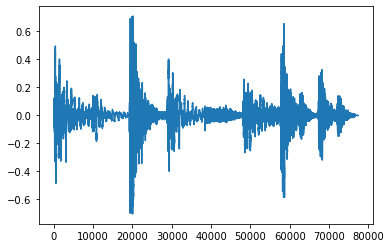

In [3]:
# Importing audio file

s, r = librosa.load('./Files/Loop.wav', sr=sr)

# Importing MIDI

#pm = pretty_midi.PrettyMIDI('filename.mid')
plt.plot(s)

In [114]:

# Fade in and out function to avoid clips when we merge segments

def fade(segment, fadesize):
    fades = np.array([])
    fadesize = fadesize
    if segment.size <= (fadesize*2):
        fadesize = int(segment.size / 10)
        midpart = np.ones(segment.size - (int(fadesize*2)))
        fadein = np.linspace(0,1,num=fadesize)
        fadeout = np.linspace(1,0,num=fadesize)
        fades = np.concatenate((fadein, midpart, fadeout))
        
    else:         
        midpart = np.ones(segment.size - (int(fadesize*2)))   
        fadein = np.linspace(0,1,num=fadesize)
        fadeout = np.linspace(1,0,num=fadesize)
        fades = np.concatenate((fadein, midpart, fadeout))
        
    y = segment * fades
    
    return y


def sizecheck(segment, result):
    if segment.size != result.size:
        if segment.size > result.size:
            diff = segment.size-result.size            
            segment = np.delete(segment_final, diff)
            
        elif result.size > segment.size:
            zeros= np.zeros(result.size - segment.size)
            
            segment = np.concatenate((segment, zeros))
    else:
        pass
    
    return segment

In [74]:
# Just added a compressor function because I wanted to try it out. Can be used for processing 

def compressor(audio, threshold, makeup, smoothness):
    x = np.array([])
    x = np.append(x, audio)
    for i in range(smoothness):
        index = 0        
        for i in x:        
            if np.abs(i) >= threshold + 0.3:
                x[index] = i * 0.85                 
            elif np.abs(i) >= threshold + 0.2:
                x[index] = i * 0.90            
            elif np.abs(i) >= threshold + 0.1:
                x[index] = i * 0.95            
            elif np.abs(i) >= threshold:
                x[index] = i * 0.99            
            else:
                x[index] = i
            index += 1
            
    y = x * (1+makeup)
    
    return y


# Try impulses between 2 and 10
def IRDelay(audio, impulses,sr=sr):    
    
    impulse_array = np.linspace(0.2, 0, num=impulses)
    IRarray = np.array([])
    size = int(audio.size/impulses)-1
    for i in range(impulses):
    
        IRarray = np.append(IRarray, np.zeros(size))
        IRarray = np.append(IRarray, impulse_array[i]) 
    
    # Y =signal.fft.sfft(audio)
    # H = signal.fft.sfft(IRarray)
    # store = Y*H
    # audio = signal.fft.isfft(store) 
    x = np.convolve(audio, IRarray)
    audio = np.append(audio, np.zeros([x.size-audio.size]))
    s = (audio+(x*0.75)*0.5)
    
    return x

def allpass(delay, gain):
    b = np.zeros(delay)
    b[0] = gain
    b[delay-1] = 1
    a = np.zeros(delay)
    a[0] = 1
    a[delay-1] = gain
    return b,a


def IIRReverb(audio, wet, combq, delay1, gain1, delay2, gain2):
    s_tail = audio
    s_tail = np.append(s_tail, np.zeros(48000))    
    
    # First comb filter
    f0 = 200  
    Q = combq  
    b1,a1 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y1 = signal.lfilter(b1,a1,s_tail)
    # Second comb filter 
    f0 = 300  
    Q = combq  
    b2,a2 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y2 = signal.lfilter(b2,a2,s_tail)
    # Third comb filter
    f0 = 400  
    Q = combq  
    b3,a3 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y3 = signal.lfilter(b3,a3,s_tail)
    # Fourth comb filter
    f0 = 500 
    Q = combq  
    b4,a4 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y4 = signal.lfilter(b4,a4,s_tail)
    # computing up the parallell structure by adding them together (and scaling the amplitude)
    comb_result = (y1 + y2 + y3 + y4)*0.2
    # Designing the two allpass filters
    b1,a1 = allpass(delay1, gain1)
    b2,a2 = allpass(delay2, gain2)

    # Convolving the coefficients to get the cascading structure
    cascade_a = np.convolve(a1,a2)
    cascade_b = np.convolve(b1,b2)

    # Run the result from the comb parallell filters through the cascade of allpass filters
    signal_output = signal.lfilter(cascade_b, cascade_a, comb_result)
    # Merging wet with dry
    #audio = np.append(audio, np.zeros([signal_output.size-audio.size]))
    #output = ((signal_output * wet)+audio)*0.5
    
    
    return signal_output


def framecompressor(audio, frame_length, threshold, ratio, makeup):
    window = signal.get_window('hann', frame_length)    
    b = np.array([-ratio])
    c = signal.convolve(window, b)
    window = c + 1
    
    x = np.array([])
    x = np.append(x, audio)
    
    for i in range(0, len(audio), int(frame_length*0.5)):
                
        s = x[i:i + frame_length]        
        a = np.max(np.abs(s))
        if a > threshold:            
            s = s * window
            x[i:i+frame_length] = s
        
    compressed = x * makeup
    return compressed

In [45]:
#b = IIRReverb(s, 0.9, 20, 800, 0.78, 1700, 0.68)
#xx = IRDelay(s, 4)
#first = framecompressor(s, 2048,0.45, 0.6, 1.7)
#sd.play(first)
#plt.plot(first)

#sd.play(b)
#sd.wait()
#sd.play(xx)

In [ ]:
# If we want to resynthesize anything these can come in handy

def sawtooth_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp * signal.sawtooth(2 *np.pi*freq*t*phase)

    return s

def triangle_synth(freq, dur_ms, sr=sr, amp=1, phase=1, width=0.5):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp * signal.sawtooth(2 *np.pi*freq*t*phase)

    return s

def sine_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp*np.sin(2*np.pi*freq*t*phase)
    
    return s
    
def square_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp*signal.square(2*np.pi*freq*t*phase)
    
    return s

def chirp_sound(freq_start, freq_end, dur_ms, amp=1):
    
    t = np.arange(0, int((dur_ms/1000)*sr)) / sr
    s = amp * signal.chirp(t, f0=freq_start, f1=freq_end, t1=dur_ms/1000, method='linear')

    return s

# Multiply the amp_envelope with your generated signal note by note 
# to get a nice smooth attack and decay

def amp_envelope(dur_ms, sr=sr):
    
    t = np.arange(0, dur_ms/1000, 1/sr)
    
    # Splitting t up into 4 parts
    attack_length = int(len(t) / 20)
    decay_length = int(len(t) / 4)
    sustain_length = int(len(t) / 2)
    release_length = int(len(t) - (attack_length + decay_length + sustain_length))
    
    # Setting the start and stop amplitube values for the ramps
    attack = np.linspace(0, 0.9, num=attack_length)
    decay = np.linspace(0.9, 0.75, num=decay_length)
    sustain = np.linspace(0.75, 0.6, num=sustain_length)
    release = np.linspace(0.6, 0, num=release_length)
    
    # Putting them together in order
    env = np.concatenate((attack, decay, sustain, release))
    
    return env

In [76]:
s, r = librosa.load('./Files/Violin.wav', sr=sr)

In [106]:
# Making a random list to have something to use for slicing in the for loop. 
# Here we need something picked up from a midi file
# Need to skip the zero
iterative = np.linspace(0, s.size, 20)
my_list = []
for number in iterative:
    if number == 0:
        continue
    else:
        my_list.append(int(number))
# To avoid issues in the last segment    
my_list = my_list[0:-1]
print(my_list)

[47035, 94071, 141107, 188143, 235179, 282215, 329251, 376287, 423323, 470358, 517394, 564430, 611466, 658502, 705538, 752574, 799610, 846646]


In [96]:
s.size


893682

47035
1
94071
2
141107
3
188143
4
235179
1
282215
2
329251
3
376287
4
423323
1
470358
2
517394
3
564430
4
611466
1
658502
2
705538
3
752574
4
799610
1
846646
2


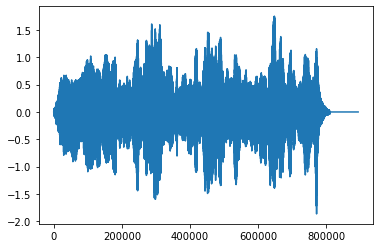

In [160]:
# Creating the result array I will add all signals back into
result = np.zeros(s.size) 

# Temporary arrays used in the for loop
segment = np.array([])
seg = np.array([])

# Making the counter
counter = 0
current_beat = 0
overlap = 0
overlap_length = 2048

# Just iterating through a random list, we'll use info from the midifile for this 

# This is the main slicing and processing part of the program

for i in my_list:
    # To check computational time and where it struggles
    print(i)
    print(counter)
    
    counter += 1
    
    # Slicing the segment from current_beat to the sample position i
    seg = s[current_beat:i]    
    # adding fade ins and outs to the segment
    segment = fade(seg, overlap_length)
    if counter == 1:
        segment = compressor(segment, 0.3, 1.2, 1)
        seg_fx = IRDelay(segment, 4)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)]) 
        segment_fx = np.pad(seg_fx,[current_beat, s.size-(current_beat+seg_fx.size)])
          
        segment_padded = (segment_padded + segment_fx)
        
    elif counter == 2:
        segment = compressor(segment, 0.3, 1.2, 1)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)])
    elif counter == 3:
        segment = compressor(segment, 0.3, 1.2, 1)
        seg_fx = IIRReverb(segment, 0.9, 20, 800, 0.78, 1700, 0.68)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)]) 
        segment_fx = np.pad(seg_fx,[current_beat, s.size-(current_beat+seg_fx.size)])
          
        segment_padded = (segment_padded + segment_fx)

    elif counter == 4: 
#        # Arvid processing goes in here
        segment = compressor(segment, 0.3, 1.2, 1)
        segment_padded = np.pad(segment,[current_beat, s.size-(current_beat+segment.size)])
#        segment_padded = IIRReverb(segment_padded, 20, 1000, 0.8, 3400, 0.7)
    
    # Setting overlap to for example 100 samples, just some ideas for the overlap
    
    # updating the current beat for the next loop
    current_beat = current_beat + seg.size
    
    segment_overlapped = segment_padded[overlap:segment_padded.size]
    
    # getting the size right again by adding zeros to the end:
    segment_final = np.pad(segment_overlapped, [0, overlap])
    # Increasing overlap for next round of for loop 
    overlap = overlap + overlap_length
    
    # Just making sure the sizes are allright 
    segment_final = sizecheck(segment_final, result)
    
    # Resetting the counter when it reaches 4
    if counter == 4:
        counter = 0
    # pasting the segments back in, one by one
    result = result + segment_final
    
# Playing back the result
    
#final = framecompressor(result, 2048,0.40, 0.5, 1.7)   
sd.play(result)
plt.plot(result)



In [161]:
print(result.size)
print(result.shape)
print(s.size)
print(s.shape)

893682
(893682,)
893682
(893682,)
